https://dropbox.tech/machine-learning/fast-and-accurate-document-detection-for-scanning

In [1]:
import math
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
size = 300
sigma = 0.33
rho_step = 1
new_size = 150
max_lines = 10
threshold = 50
score_thickness = 3
theta_step = np.pi / 180
angle_tolerance = 10 * np.pi / 180

In [3]:
image_file = 'popsike/18501373.jpg'

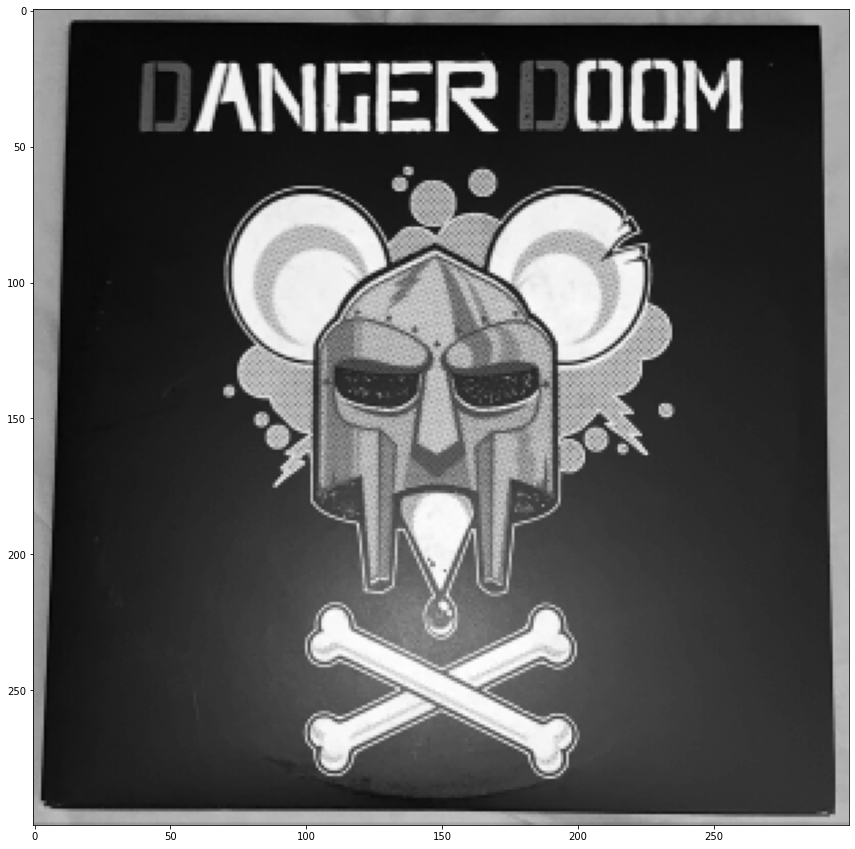

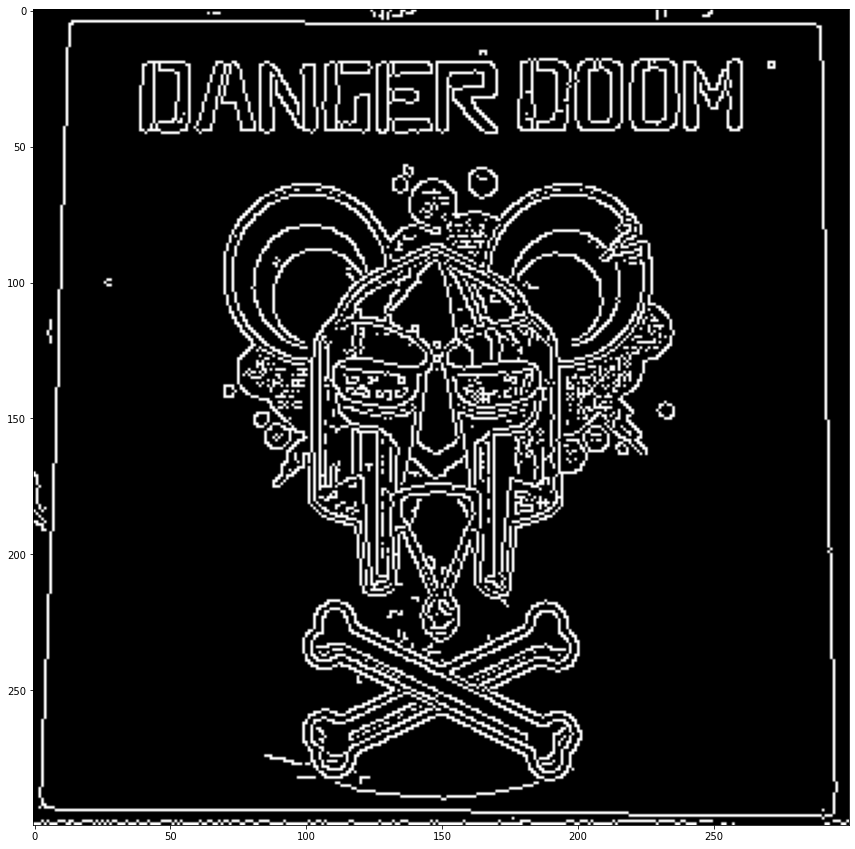

In [4]:
img = cv.imread(image_file, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (size,size), interpolation = cv.INTER_AREA) 

v = np.median(img)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edges = cv.Canny(img, lower, upper)
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img, cmap="gray")
plt.show()
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(edges, cmap="gray")
plt.show()

In [5]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [(x0, y0)]

In [6]:
def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [7]:
lines = cv.HoughLines(edges, rho_step, theta_step, threshold)
horizontal_lines = [line for line in lines if np.pi / 2 - angle_tolerance < line[0][1] < np.pi / 2 + angle_tolerance or
                   3 * np.pi / 2 - angle_tolerance < line[0][1] < 3 * np.pi / 2 + angle_tolerance]
vertical_lines = [line for line in lines if line[0][1] < angle_tolerance or line[0][1] > 2 * np.pi - angle_tolerance or
                 np.pi - angle_tolerance < line[0][1] < np.pi + angle_tolerance]

In [8]:
intersections = segmented_intersections([horizontal_lines[:max_lines], vertical_lines[:max_lines]])

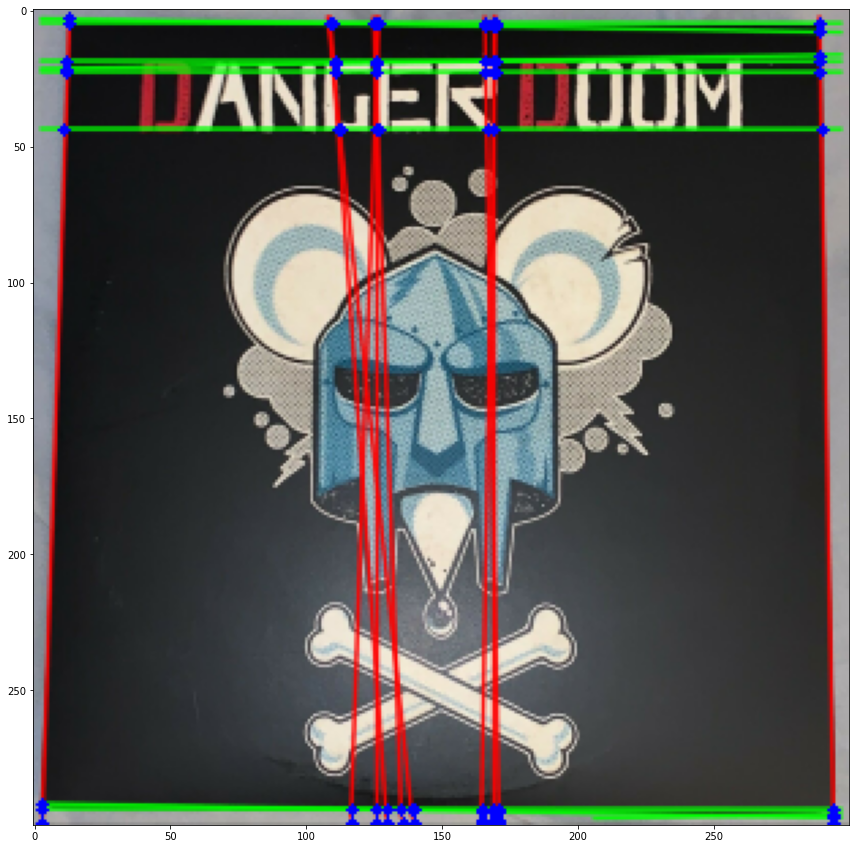

In [9]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

for line in vertical_lines[:max_lines]:
    rho = line[0][0]
    theta = line[0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(img, pt1, pt2, (255, 0, 0), 1, cv.LINE_AA)
    
for line in horizontal_lines[:max_lines]:
    rho = line[0][0]
    theta = line[0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(img, pt1, pt2, (0, 255, 0), 1, cv.LINE_AA)

for point in intersections:
    cv.circle(img, (point[0][0], point[0][1]), 2, (0, 0, 255), -1)
    
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

In [10]:
top_left_corners = set(point[0] for point in intersections if 0 < point[0][0] < size / 4 and 0 < point[0][1] < size / 4)
top_right_corners = set(point[0] for point in intersections if size > point[0][0] > 3 * size / 4 and 0 < point[0][1] < size / 4)
bottom_left_corners = set(point[0] for point in intersections if 0 < point[0][0] < size / 4 and size > point[0][1] > 3 * size / 4)
bottom_right_corners = set(point[0] for point in intersections if size > point[0][0] > 3 * size / 4 and size > point[0][1] > 3 * size / 4)

In [11]:
len(top_left_corners), len(top_right_corners), len(bottom_left_corners), len(bottom_right_corners)

(6, 6, 3, 4)

In [12]:
def score_line(edges, point_1, point_2):
    return np.tensordot(edges, cv.line(np.zeros(edges.shape), point_1, point_2, (255,), score_thickness, cv.LINE_AA))

In [13]:
top_lines = sorted([
    (score_line(edges, top_left_corner, top_right_corner), top_left_corner, top_right_corner)
    for top_left_corner in top_left_corners
    for top_right_corner in top_right_corners
], reverse=True)

In [14]:
right_lines = sorted([
    (score_line(edges, top_right_corner, bottom_right_corner), top_right_corner, bottom_right_corner)
    for top_right_corner in top_right_corners
    for bottom_right_corner in bottom_right_corners
], reverse=True)

In [15]:
bottom_lines = sorted([
    (score_line(edges, bottom_right_corner, bottom_left_corner), bottom_right_corner, bottom_left_corner)
    for bottom_right_corner in bottom_right_corners
    for bottom_left_corner in bottom_left_corners
], reverse=True)

In [16]:
left_lines = sorted([
    (score_line(edges, bottom_left_corner, top_left_corner), bottom_left_corner, top_left_corner)
    for bottom_left_corner in bottom_left_corners
    for top_left_corner in top_left_corners
], reverse=True)

In [17]:
quadrilaterals = sorted([
    (top_line[0] + right_line[0] + bottom_line[0] + left_line[0], top_line[1], right_line[1], bottom_line[1], left_line[1])
    for top_line in top_lines
    for right_line in right_lines if right_line[1] == top_line[2]
    for bottom_line in bottom_lines if bottom_line[1] == right_line[2]
    for left_line in left_lines if left_line[1] == bottom_line[2] and left_line[2] == top_line[1]
], reverse=True)

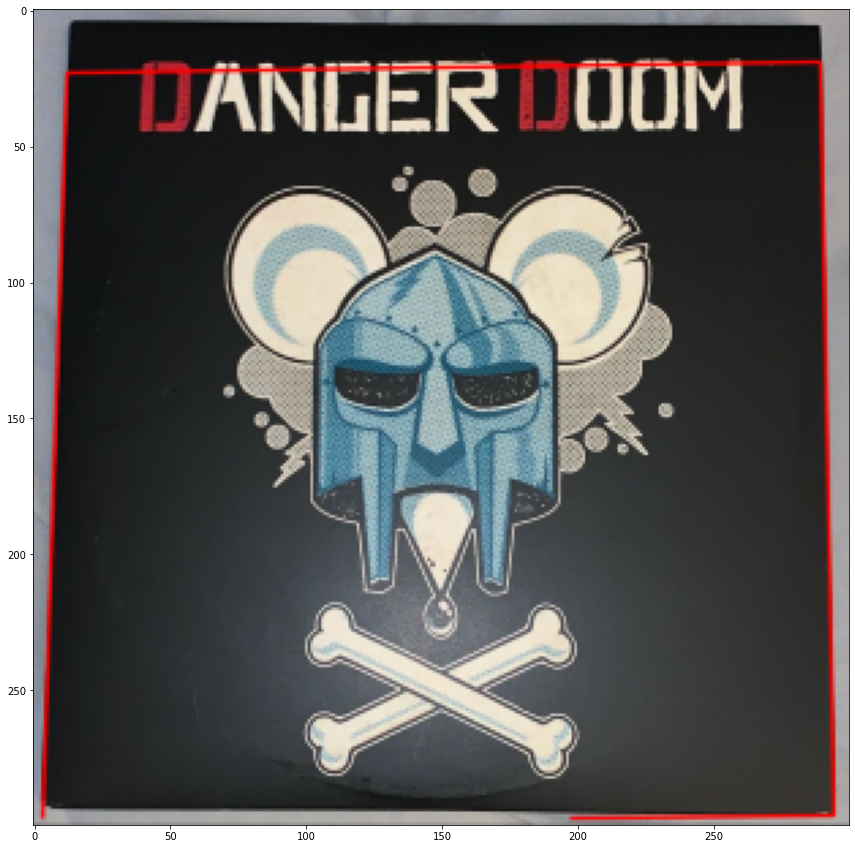

In [18]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

cv.line(img, quadrilaterals[0][1], quadrilaterals[0][2], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][2], quadrilaterals[0][3], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][3], quadrilaterals[0][4], (255, 0, 0), 1, cv.LINE_AA)
cv.line(img, quadrilaterals[0][4], quadrilaterals[0][1], (255, 0, 0), 1, cv.LINE_AA)

fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

In [19]:
M = cv.getPerspectiveTransform(np.float32([
    [quadrilaterals[0][1][0], quadrilaterals[0][1][1]],
    [quadrilaterals[0][2][0], quadrilaterals[0][2][1]],
    [quadrilaterals[0][3][0], quadrilaterals[0][3][1]],
    [quadrilaterals[0][4][0], quadrilaterals[0][4][1]],
]), np.float32([
    [0, 0],
    [new_size, 0],
    [new_size, new_size],
    [0, new_size]
]))

In [20]:
img = cv.imread(image_file, cv.IMREAD_COLOR)
img = cv.resize(img, (size, size), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
new_img = cv.warpPerspective(img, M, (size, size))[:new_size, :new_size, :]

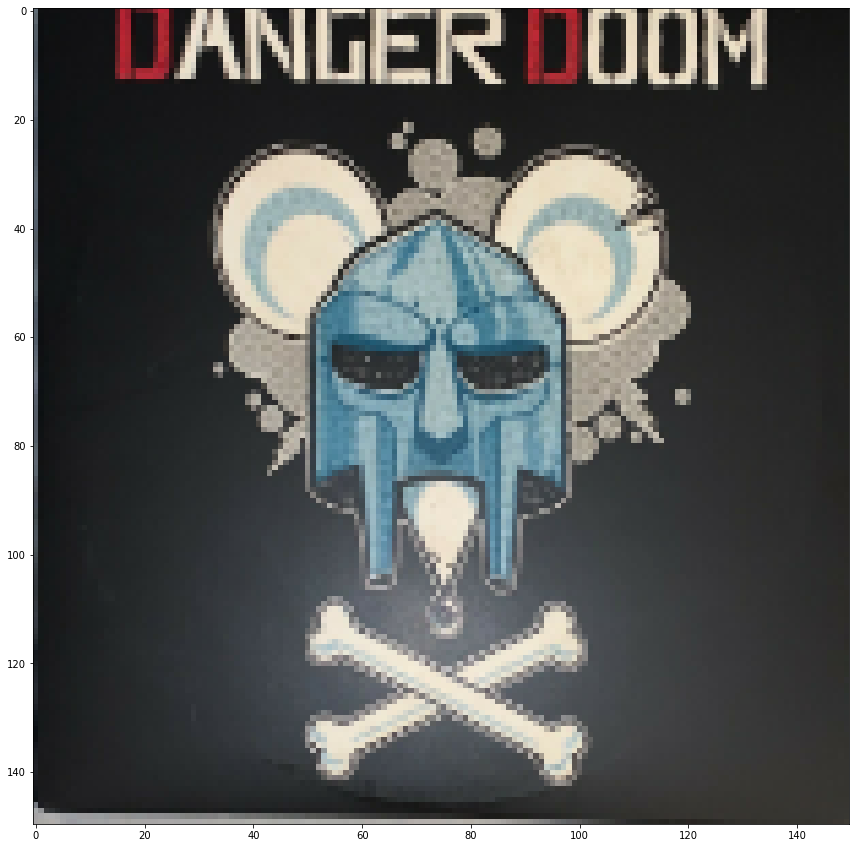

In [21]:
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(new_img)
plt.show()

In [23]:
img = cv.imread(f'thumbs/thumb_{image_file[8:-4]}.jpg', cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize = (15, 15))
fig.add_subplot().imshow(img)
plt.show()

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [23]:
from PIL import Image as im
im.fromarray(new_img).save(f'cropped_{image_file[:-4]}.png')

* Speed up by calculating score over smallest area containing line
* Lower resolution corner points
* top_lines{point_1[0] * size + point_1[1]} = (point_1, [(score, point_2), ...])